In [16]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

In [17]:

import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [18]:
model = SentenceTransformer("all-MiniLM-L6-v2")
X_train = model.encode(train_df["query"].tolist(), convert_to_tensor=True)
X_val = model.encode(val_df["query"].tolist(), convert_to_tensor=True)
X_test = model.encode(test_df["query"].tolist(), convert_to_tensor=True)

X_train = X_train.unsqueeze(1).to(device)
X_val   = X_val.unsqueeze(1).to(device)
X_test  = X_test.unsqueeze(1).to(device)

y_train = torch.tensor(train_df["carb"].values, dtype=torch.float32).unsqueeze(1).to(device)
y_val   = torch.tensor(val_df["carb"].values, dtype=torch.float32).unsqueeze(1).to(device)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test)

print(f"Data loaded on device: {X_train.device}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Data loaded on device: cuda:0
X_train shape: torch.Size([8000, 1, 384])
y_train shape: torch.Size([8000, 1])


In [19]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [20]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size=384, hidden_size=128, num_layers=3, dropout=0.4, bidirectional=False):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0, 
            bidirectional=bidirectional, 
            nonlinearity='relu'
            )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])    


In [ ]:

def train_epoch(model, optimizer, train_loader, criterion, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            loss = nn.MSELoss()(preds, y_batch)
            total_loss += loss.item()
    return (total_loss / len(val_loader)) ** 0.5

configurations = [
    {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-5, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3},
    {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 1e-4, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3},
    {'optimizer': 'Adam', 'lr': 0.002, 'batch_size': 32, 'weight_decay': 1e-5, 'hidden_size': 256, 'num_layers': 2, 'dropout': 0.4},
    {'optimizer': 'AdaGrad', 'lr': 0.01, 'batch_size': 32, 'weight_decay': 1e-4, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3},
    {'optimizer': 'SGD', 'lr': 0.01, 'batch_size': 32, 'weight_decay': 1e-4, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3},
    {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-5, 'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2},
    {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-5, 'hidden_size': 256, 'num_layers': 3, 'dropout': 0.4},
    {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-5, 'hidden_size': 512, 'num_layers': 2, 'dropout': 0.4},
    {'optimizer': 'Adam', 'lr': 0.0001, 'batch_size': 32, 'weight_decay': 1e-5, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3},
    {'optimizer': 'Adam', 'lr': 0.005, 'batch_size': 32, 'weight_decay': 1e-5, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3},
]

results = []

print("Starting hyperparameter optimization...")
print("="*60)

for i, config in enumerate(configurations):
    print(f"\n{'='*60}")
    print(f"Configuration {i+1}: {config}")
    print(f"{'='*60}")
    
    # Create data loaders with current batch size
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'])
    
    # Initialize model with current configuration
    model = RNN(
        input_size=384,
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers'],
        dropout=config['dropout'],
        bidirectional=False
    ).to(device)
    
    criterion = nn.MSELoss()
    
    # Initialize optimizer with current configuration
    if config['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'AdaGrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=config['weight_decay'])
    
    # Training loop
    best_val_rmse = float('inf')
    epochs_without_improvement = 0
    train_losses = []
    val_rmses = []
    
    for epoch in range(50):  # Reduced epochs for hyperparameter search
        train_loss = train_epoch(model, optimizer, train_loader, criterion, device)
        val_rmse = evaluate(model, val_loader, device)
        
        train_losses.append(train_loss)
        val_rmses.append(val_rmse)
        
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val RMSE = {val_rmse:.4f}")
        
        if epochs_without_improvement >= 10:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    print(f"Final Best Validation RMSE: {best_val_rmse:.4f}")
    
    result = config.copy()
    result['best_val_rmse'] = best_val_rmse
    result['final_epoch'] = epoch + 1
    result['train_losses'] = train_losses
    result['val_rmses'] = val_rmses
    results.append(result)

results_sorted = sorted(results, key=lambda x: x['best_val_rmse'])

print(f"\n{'='*60}")
print("HYPERPARAMETER OPTIMIZATION COMPLETE")
print(f"{'='*60}")
print(f"Best configuration: {results_sorted[0]}")
print(f"Best validation RMSE: {results_sorted[0]['best_val_rmse']:.4f}")
    

Starting hyperparameter optimization...

Configuration 1: {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-05, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3}
Epoch 1: Train Loss = 1768.8476, Val RMSE = 35.3471
Epoch 11: Train Loss = 849.6239, Val RMSE = 31.0699
Epoch 21: Train Loss = 517.6613, Val RMSE = 28.4209
Epoch 31: Train Loss = 348.4733, Val RMSE = 25.5417
Epoch 41: Train Loss = 277.4462, Val RMSE = 24.1206
Final Best Validation RMSE: 22.7133

Configuration 2: {'optimizer': 'Adam', 'lr': 0.0005, 'batch_size': 32, 'weight_decay': 0.0001, 'hidden_size': 128, 'num_layers': 2, 'dropout': 0.3}
Epoch 1: Train Loss = 1879.7362, Val RMSE = 36.9734
Epoch 11: Train Loss = 1106.2323, Val RMSE = 31.9111
Epoch 21: Train Loss = 819.5701, Val RMSE = 30.4492
Epoch 31: Train Loss = 577.5216, Val RMSE = 29.6711
Epoch 41: Train Loss = 457.0821, Val RMSE = 27.4995
Final Best Validation RMSE: 25.6758

Configuration 3: {'optimizer': 'Adam', 'lr': 0.002, 'batch_size': 32, 

In [7]:
best_config = results_sorted[0]
print(f"Training final model with best configuration: {best_config}")
train_loader_final = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=True)
val_loader_final = DataLoader(val_dataset, batch_size=best_config['batch_size'])
test_loader_final = DataLoader(test_dataset, batch_size=best_config['batch_size'])


final_model = RNN(
    input_size=384,
    hidden_size=best_config['hidden_size'],
    num_layers=best_config['num_layers'],
    dropout=best_config['dropout'],
    bidirectional=False
).to(device)

criterion = nn.MSELoss()
print(f"Final model architecture: Hidden size: {best_config['hidden_size']}, "
      f"Layers: {best_config['num_layers']}, Dropout: {best_config['dropout']}")


if best_config['optimizer'] == 'Adam':
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_config['lr'], weight_decay=best_config['weight_decay'])
elif best_config['optimizer'] == 'AdaGrad':
    optimizer = torch.optim.Adagrad(final_model.parameters(), lr=best_config['lr'], weight_decay=best_config['weight_decay'])
elif best_config['optimizer'] == 'SGD':
    optimizer = torch.optim.SGD(final_model.parameters(), lr=best_config['lr'], momentum=0.9, weight_decay=best_config['weight_decay'])

print("Training final model...")
best_val_rmse = float('inf')
epochs_without_improvement = 0
final_train_losses = []
final_val_rmses = []

for epoch in range(100):
    train_loss = train_epoch(final_model, optimizer, train_loader_final, criterion, device)
    val_rmse = evaluate(final_model, val_loader_final, device)
    
    # Calculate training RMSE
    train_rmse = train_loss ** 0.5
    # Calculate validation loss (MSE)
    val_loss = val_rmse ** 2
    
    final_train_losses.append(train_loss)
    final_val_rmses.append(val_rmse)
    
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        epochs_without_improvement = 0
        torch.save(final_model.state_dict(), 'best_rnn_model.pth')
    else:
        epochs_without_improvement += 1
    
    # Print training metrics for every epoch
    print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:8.4f} | Train RMSE = {train_rmse:8.4f} | Val Loss = {val_loss:8.4f} | Val RMSE = {val_rmse:8.4f}")
    
    if epochs_without_improvement >= 15:
        print(f"Early stopping at epoch {epoch+1}")
        break

final_model.load_state_dict(torch.load('best_rnn_model.pth'))
print(f"Final model validation RMSE: {best_val_rmse:.4f}")
final_model.eval()
all_preds = []

with torch.no_grad():
    for X_batch, in test_loader_final:
        X_batch = X_batch.to(device)
        preds = final_model(X_batch).cpu().numpy()
        all_preds.extend(preds)

test_df["carb"] = all_preds
test_df.to_csv("test_with_predictions_rnn.csv", index=False)
print(f"Test predictions saved to test_with_predictions_rnn.csv")
print(f"Generated {len(all_preds)} predictions for test set")
print(f"Sample predictions: {all_preds[:5]}")
print(f"Prediction statistics - Mean: {np.mean(all_preds):.4f}, Std: {np.std(all_preds):.4f}")


Training final model with best configuration: {'optimizer': 'Adam', 'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-05, 'hidden_size': 512, 'num_layers': 2, 'dropout': 0.4, 'best_val_rmse': 18.68773759234321, 'final_epoch': 50, 'train_losses': [1614.9021640319825, 1315.2736741027832, 1172.101729888916, 1055.0960603637695, 945.1223760681153, 850.4634759521484, 771.0718247680664, 680.4472080993652, 602.8461710357666, 534.5901013793946, 492.2170684814453, 466.45066647338865, 426.029778137207, 399.25493453979493, 357.67804530334473, 328.154308883667, 339.6097822418213, 317.3077158355713, 269.66319120788575, 269.08240632629395, 267.84975968933105, 236.9883448486328, 239.5967328338623, 230.8706732635498, 229.76738176727295, 202.5767962875366, 200.08313400268554, 194.20081343078613, 191.29859839630126, 205.3981643295288, 198.55443374633788, 179.8480263671875, 170.48983682250977, 141.20415274047852, 163.90847397613524, 190.9552197494507, 183.4282710723877, 146.66241492462157, 134.64909994506

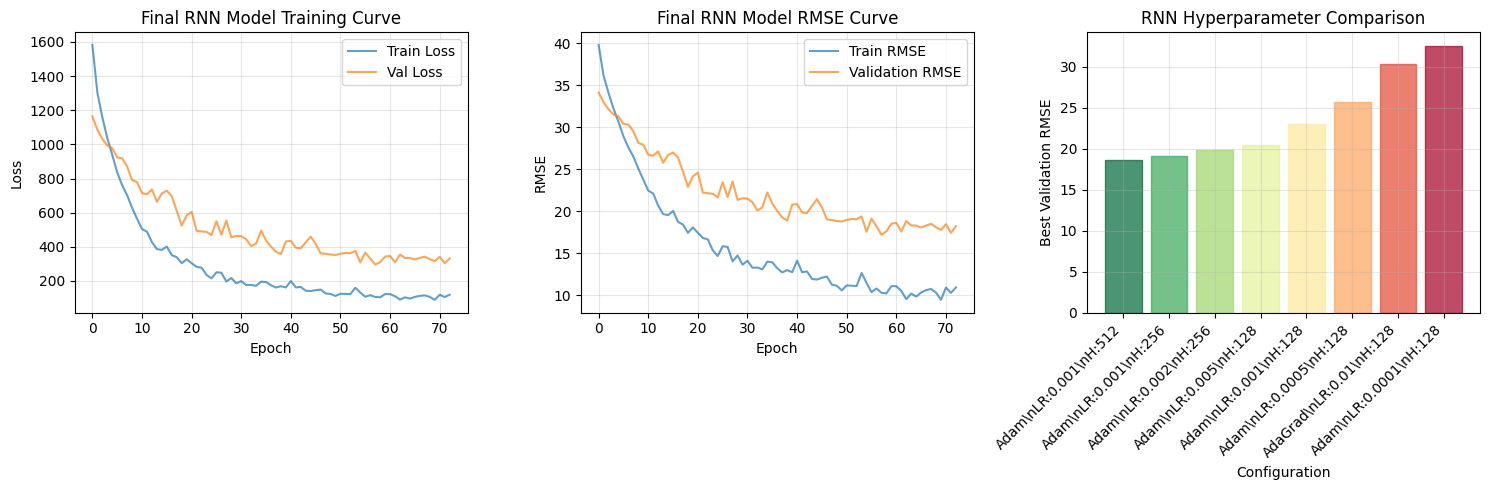

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(final_train_losses, label='Train Loss', alpha=0.7)
plt.plot([rmse**2 for rmse in final_val_rmses], label='Val Loss', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final RNN Model Training Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot([loss**0.5 for loss in final_train_losses], label='Train RMSE', alpha=0.7)
plt.plot(final_val_rmses, label='Validation RMSE', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Final RNN Model RMSE Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
rmse_values = [result['best_val_rmse'] for result in results_sorted[:8]]
config_labels = [f"{r['optimizer']}\\nLR:{r['lr']}\\nH:{r['hidden_size']}" for r in results_sorted[:8]]
bars = plt.bar(range(len(rmse_values)), rmse_values, alpha=0.7)
plt.xlabel('Configuration')
plt.ylabel('Best Validation RMSE')
plt.title('RNN Hyperparameter Comparison')
plt.xticks(range(len(config_labels)), config_labels, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

for i, bar in enumerate(bars):
    normalized_color = i / (len(bars) - 1)
    bar.set_color(plt.cm.RdYlGn_r(normalized_color))

plt.tight_layout()
plt.savefig("rnn_training_analysis.png", dpi=300, bbox_inches='tight')
plt.show()


In [9]:
print("="*80)
print("RNN HYPERPARAMETER OPTIMIZATION SUMMARY")
print("="*80)
print("\nTested configurations:")
for i, config in enumerate(configurations):
    result = next(r for r in results if r['optimizer'] == config['optimizer'] and 
                  r['lr'] == config['lr'] and r['batch_size'] == config['batch_size'] and
                  r['hidden_size'] == config['hidden_size'])
    print(f"{i+1}. {config['optimizer']} | LR: {config['lr']} | Batch: {config['batch_size']} | "
          f"Hidden: {config['hidden_size']} | Layers: {config['num_layers']} | RMSE: {result['best_val_rmse']:.4f}")

print(f"\nKey Findings:")
print(f"- Best performing optimizer: {results_sorted[0]['optimizer']}")
print(f"- Best learning rate: {results_sorted[0]['lr']}")
print(f"- Best batch size: {results_sorted[0]['batch_size']}")
print(f"- Best hidden size: {results_sorted[0]['hidden_size']}")
print(f"- Best number of layers: {results_sorted[0]['num_layers']}")
print(f"- Best dropout rate: {results_sorted[0]['dropout']}")
print(f"- Best validation RMSE: {results_sorted[0]['best_val_rmse']:.4f}")

print(f"\nPerformance by optimizer:")
for opt in ['Adam', 'AdaGrad', 'SGD']:
    opt_results = [r for r in results if r['optimizer'] == opt]
    if opt_results:
        best_opt = min(opt_results, key=lambda x: x['best_val_rmse'])
        avg_rmse = np.mean([r['best_val_rmse'] for r in opt_results])
        print(f"- {opt}: Best RMSE = {best_opt['best_val_rmse']:.4f}, Average RMSE = {avg_rmse:.4f}")

print(f"\nPerformance by hidden size:")
for hs in [64, 128, 256, 512]:
    hs_results = [r for r in results if r['hidden_size'] == hs]
    if hs_results:
        best_hs = min(hs_results, key=lambda x: x['best_val_rmse'])
        avg_rmse = np.mean([r['best_val_rmse'] for r in hs_results])
        print(f"- Hidden size {hs}: Best RMSE = {best_hs['best_val_rmse']:.4f}, Average RMSE = {avg_rmse:.4f}")

print(f"\nPerformance by number of layers:")
for nl in [1, 2, 3]:
    nl_results = [r for r in results if r['num_layers'] == nl]
    if nl_results:
        best_nl = min(nl_results, key=lambda x: x['best_val_rmse'])
        avg_rmse = np.mean([r['best_val_rmse'] for r in nl_results])
        print(f"- {nl} layers: Best RMSE = {best_nl['best_val_rmse']:.4f}, Average RMSE = {avg_rmse:.4f}")

print(f"\nPerformance by dropout rate:")
for dr in [0.2, 0.3, 0.4, 0.5]:
    dr_results = [r for r in results if r['dropout'] == dr]
    if dr_results:
        best_dr = min(dr_results, key=lambda x: x['best_val_rmse'])
        avg_rmse = np.mean([r['best_val_rmse'] for r in dr_results])
        print(f"- Dropout {dr}: Best RMSE = {best_dr['best_val_rmse']:.4f}, Average RMSE = {avg_rmse:.4f}")

print(f"\nTop 5 configurations:")
for i, result in enumerate(results_sorted[:5]):
    print(f"{i+1}. RMSE: {result['best_val_rmse']:.4f} | {result['optimizer']} | "
          f"LR: {result['lr']} | Hidden: {result['hidden_size']} | "
          f"Layers: {result['num_layers']} | Dropout: {result['dropout']}")

print(f"\nFinal model performance:")
print(f"- Training completed in {len(final_train_losses)} epochs")
print(f"- Final validation RMSE: {best_val_rmse:.4f}")
print(f"- Improvement over best hyperparameter search: {results_sorted[0]['best_val_rmse'] - best_val_rmse:.4f} RMSE points")


RNN HYPERPARAMETER OPTIMIZATION SUMMARY

Tested configurations:
1. Adam | LR: 0.001 | Batch: 32 | Hidden: 128 | Layers: 2 | RMSE: 23.0293
2. Adam | LR: 0.0005 | Batch: 32 | Hidden: 128 | Layers: 2 | RMSE: 25.6758
3. Adam | LR: 0.002 | Batch: 64 | Hidden: 256 | Layers: 3 | RMSE: 19.8670
4. AdaGrad | LR: 0.01 | Batch: 32 | Hidden: 128 | Layers: 2 | RMSE: 30.3525
5. SGD | LR: 0.01 | Batch: 32 | Hidden: 128 | Layers: 2 | RMSE: 39.2387
6. Adam | LR: 0.001 | Batch: 32 | Hidden: 64 | Layers: 1 | RMSE: 33.0397
7. Adam | LR: 0.001 | Batch: 32 | Hidden: 256 | Layers: 3 | RMSE: 19.1320
8. Adam | LR: 0.001 | Batch: 32 | Hidden: 512 | Layers: 2 | RMSE: 18.6877
9. Adam | LR: 0.0001 | Batch: 32 | Hidden: 128 | Layers: 2 | RMSE: 32.5881
10. Adam | LR: 0.005 | Batch: 32 | Hidden: 128 | Layers: 2 | RMSE: 20.4571

Key Findings:
- Best performing optimizer: Adam
- Best learning rate: 0.001
- Best batch size: 32
- Best hidden size: 512
- Best number of layers: 2
- Best dropout rate: 0.4
- Best validation R

In [ ]:
import seaborn as sns

class SentenceEmbeddingInterpreter:
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        x.requires_grad = True
        self.input_tensor = x
        output = self.model(x)
        return output

    def zero_grad(self):
        self.model.zero_grad()
        if self.input_tensor.grad is not None:
            self.input_tensor.grad.zero_()

    def get_token_importance(self):
        grads = self.input_tensor.grad.detach().cpu().squeeze()
        inputs = self.input_tensor.detach().cpu().squeeze()
        importance = (grads * inputs).tolist()
        return importance

def visualize_sentence_embedding_importance(tokens, importances, filename=None):
    min_len = min(len(tokens), len(importances))
    tokens = tokens[:min_len]
    importances = importances[:min_len]

    fig, ax = plt.subplots(figsize=(15, 2.5))
    sns.heatmap([importances], annot=[tokens], cmap="RdBu_r", fmt="", cbar=True, ax=ax,
                center=0, cbar_kws={'label': 'Importance Score'})
    ax.set_title("Token Importance Heatmap")
    ax.set_xlabel("Tokens")
    ax.set_ylabel("")
    ax.set_yticklabels([])
    
    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()
    plt.close()

Sample 1: 'One cup of black beans and brown rice.'
Actual: 39.78g, Predicted: 48.91g


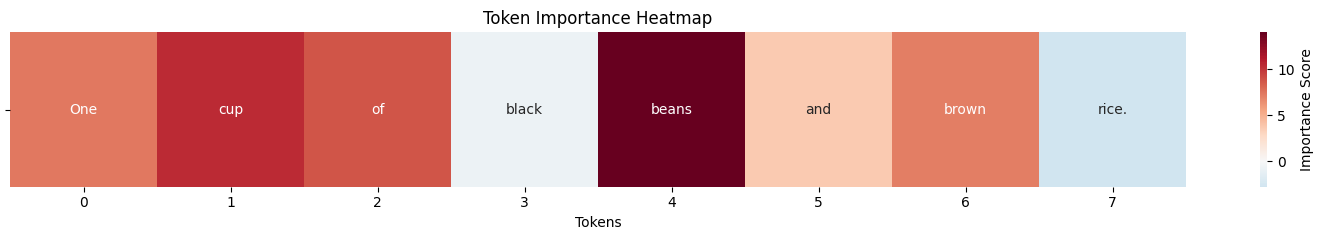

Sample 2: 'Half a roasted duck with skin removed.'
Actual: 0.00g, Predicted: 2.03g


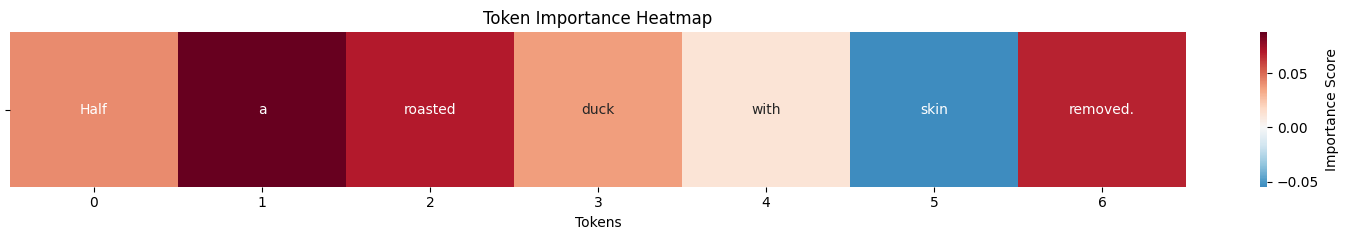

Sample 3: 'One large boiled potato with peel and some fat added.'
Actual: 61.35g, Predicted: 62.70g


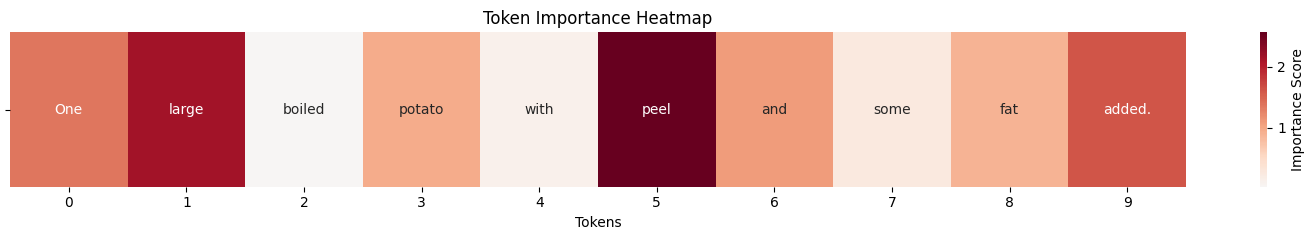

Sample 4: 'One large burrito filled with beans and cheese.'
Actual: 84.02g, Predicted: 75.14g


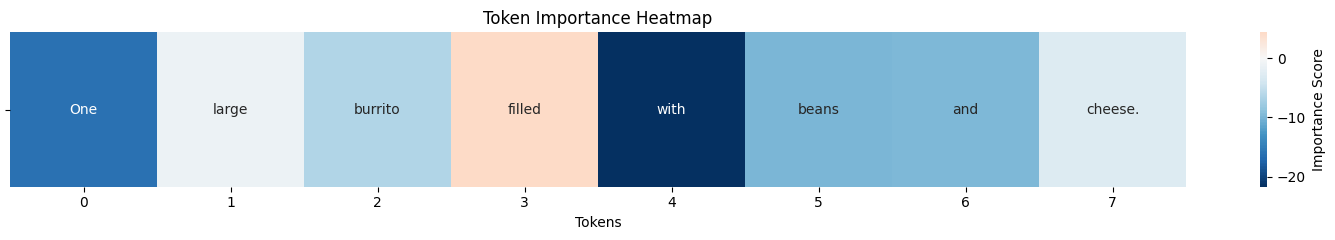

RNN(
  (rnn): RNN(384, 512, num_layers=2, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
final_model.train()

for i in range(0, 4):
    sample_idx = 3 * i
    
    sentence = val_df["query"].iloc[sample_idx]
    tokens = sentence.split()
    actual_carb = y_val[sample_idx].item()
    
    sample_x = X_val[sample_idx:sample_idx+1].requires_grad_().to(device)
    
    interpreter = SentenceEmbeddingInterpreter(final_model)
    output = interpreter.forward(sample_x)
    interpreter.zero_grad()
    
    target_tensor = y_val[sample_idx:sample_idx+1]
    loss = (output - target_tensor) ** 2
    loss.backward()
    
    importances = interpreter.get_token_importance()
    
    print(f"Sample {i+1}: '{sentence}'")
    print(f"Actual: {actual_carb:.2f}g, Predicted: {output.item():.2f}g")
    
    if len(tokens) > 1:
        dims_per_token = len(importances) // len(tokens)
        token_importances = []
        
        for j in range(len(tokens)):
            start_idx = j * dims_per_token
            end_idx = min((j + 1) * dims_per_token, len(importances))
            token_importance = np.mean(importances[start_idx:end_idx])
            token_importances.append(token_importance)
        
        visualize_sentence_embedding_importance(
            tokens, 
            token_importances, 
            filename=f"Token_Importance_RNN_index_{sample_idx}.png"
        )

final_model.eval()
